# <center> Credit Score Classification


<div>
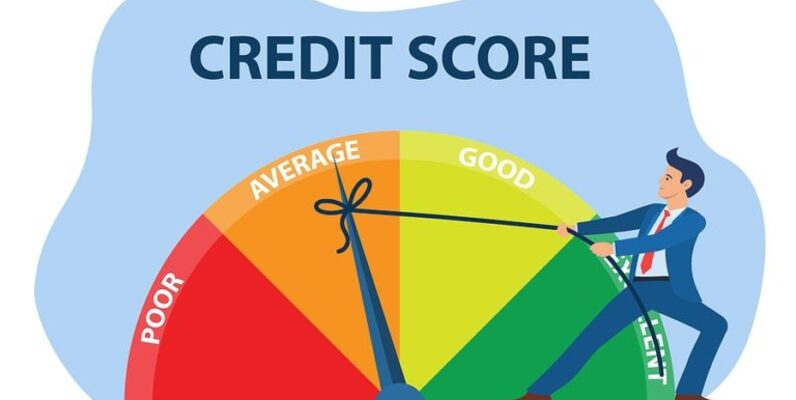
</div>

### Problem Statement
- You are working as a data scientist in a global finance company. Over the years, the company has collected basic bank details and gathered a lot of credit-related information. The management wants to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts.

### Task
- Given a person’s credit-related information, build a machine learning model that can classify the credit score.

## Table of content 
- Packages importing 
- Reading Data 
- Data Exploration
- Data cleaning 
- Data Preprocessing 
- Modeling & Evaluation


## Packages importing 

In [18]:
# Packages for EDA 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np 

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from datasist.structdata import detect_outliers
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import category_encoders as ce
import re 

# Modeling and evaluation 
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
import joblib

# Packages options 
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all 
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;

import warnings 
warnings.filterwarnings("ignore")

## Reading Data 

In [ ]:
df = pd.read_csv("Data\\train.csv",low_memory=False)

In [ ]:
df.sample(10)

## Data Exploration

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.duplicated().sum()

In [ ]:
sns.countplot(df['Month'],palette="mako");

In [ ]:
sns.countplot(df['Occupation'],palette="mako");
plt.xticks(rotation=45);

In [ ]:
sns.countplot(df['Credit_Mix'],palette="mako");
plt.xticks(rotation=45);

In [ ]:
sns.countplot(df['Payment_of_Min_Amount'],palette="mako");
plt.xticks(rotation=45);

In [ ]:
sns.countplot(df['Payment_Behaviour'],palette="mako");
plt.xticks(rotation=45);

# Plotting The Target 

In [ ]:
sns.countplot(df['Credit_Score'],palette="mako");
plt.xticks(rotation=45);

In [ ]:
df['Credit_Score'].value_counts(normalize=True)

In [ ]:
sns.distplot(df['Monthly_Inhand_Salary']);

In [ ]:
sns.distplot(df['Num_Bank_Accounts']);

In [ ]:
sns.distplot(df['Num_Credit_Card']);

In [ ]:
sns.distplot(df['Interest_Rate']);

In [ ]:
sns.distplot(df['Delay_from_due_date']);

In [ ]:
sns.distplot(df['Num_Credit_Inquiries']);

In [ ]:
sns.distplot(df['Credit_Utilization_Ratio']);

In [ ]:
sns.distplot(df['Total_EMI_per_month']);

In [ ]:
df['Type_of_Loan'].value_counts().head(10)

### Identify issues 
1. ~~ID, Name and SSN (Not useful)~~
2. Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Amount_invested_monthly, Outstanding_Debt Credit_Mix, Monthly_Balance __Numerical but show as catogery (need to be fixed)__
3. Occupation, Credit_Mix has value "_____"
4. Data contains outliers 
5. Num_Credit_Card has __zeros__
6. Type_of_Loan Need to rewrite as 8 columns 
7. Num_Bank_Accounts contains negative values
8. Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,'Credit_Mix' (needs Feature Engineering)
9. Target Columns is Imbalanced
10. A lot of missing data 

## Data cleaning

#### removing unuseful Columns (Uniques)

In [ ]:
del df['ID'] # Identification 
del df['Name'] # Name of client 
del df['SSN'] # SSN (social security number of a person)

#### Fix Numerical Columns 

1. replace _  
2. convert into float 

In [ ]:
N_to_fix = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Amount_invested_monthly', 'Outstanding_Debt' , 'Monthly_Balance']

In [ ]:
def fix_nums(num):
    try : 
        return float(num.replace("_",""))
    except :
        return np.nan

In [ ]:
for col in N_to_fix :
    df[col] = df[col].apply(fix_nums)

### Type_of_Loan

In [ ]:
## Rebuild Type of loans Columns 
for i in df['Type_of_Loan'].value_counts().head(9).index[1:] : 
    df[i] = df['Type_of_Loan'].str.contains(i)

del df['Type_of_Loan']

#### Num_Bank_Accounts

In [ ]:
df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x :abs (x))

#### Num_Credit_Card

In [ ]:
df['Num_Credit_Card'].replace(0,1,inplace=True)

#### Credit_History_Age

In [ ]:
def History_age(age):
    try : 
        years = int("".join(re.findall('[0-9]',''.join(age.split("and")[0]))))
        month = int("".join(re.findall('[0-9]',''.join(age.split("and")[1]))))
        return years*12 + month
    except :
        return np.nan

In [ ]:
df['Credit_History_Age'] = df['Credit_History_Age'].apply(History_age)

#### Payment_of_Min_Amount

In [ ]:
df['Payment_of_Min_Amount'].replace("NM","No",inplace=True)

In [ ]:
df['Payment_of_Min_Amount'].value_counts()

#### Payment_Behaviour

In [ ]:
df['Payment_Behaviour']= df['Payment_Behaviour'].replace("!@9#%8",np.nan)

In [ ]:
df['Payment_Behaviour'].value_counts()

### Occupation

In [ ]:
df['Occupation'].value_counts()

In [ ]:
occs = df['Occupation'].value_counts().index[1:]
occs

In [ ]:
id_ = "CUS_0xb891"
oc = df[df['Customer_ID'] == id_]['Occupation'].mode()[0]
df[df['Customer_ID'] == id_].replace("_______",oc)

In [ ]:
for ID in df[df['Occupation'] == "_______"]['Customer_ID'] : 
    oc = df[df['Customer_ID'] == ID]['Occupation'].mode()[0]
    df[df['Customer_ID'] == ID] = df[df['Customer_ID'] == ID].replace("_______",oc)

In [ ]:
df['Occupation'].value_counts()

In [ ]:
df['Occupation'] = df['Occupation'].replace("_______",df['Occupation'].mode()[0])

In [ ]:
df['Occupation'].value_counts()

#### Credit_Mix

In [ ]:
df['Credit_Mix'].value_counts()

In [ ]:
m = {
    "Bad":0,
    "Standard":1,
    "Good":2,
    "_":np.nan
}

In [ ]:
df['Credit_Mix'] = df['Credit_Mix'].map(m)

### Advanced Handling Missing Data 

In [ ]:
# Edit Columns from bool to int 
for col in list(df.columns[-8:]):
    df[col] = df[col].astype(float)

In [ ]:
IDs = 1 
for ID in df['Customer_ID'].unique() :
    df['Customer_ID'] = df['Customer_ID'].replace(ID,IDs)
    IDs += 1 

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

In [ ]:
Numericals = df.select_dtypes(exclude='object').columns[1:]
Numericals

In [ ]:
for col in Numericals[1:]:
    imputer.fit(df[['Customer_ID',col]])
    df[['Customer_ID',col]] = imputer.transform(df[['Customer_ID',col]])

In [ ]:
df.info()

In [ ]:
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df[['Payment_Behaviour']])
df[['Payment_Behaviour']] = imputer.transform(df[['Payment_Behaviour']])

### Handling Outliers 

In [ ]:
## replace Outliers with median 
for col in Numericals :
    outliers_indecies = detect_outliers(df,0,[col])
    median = df[col].median()
    df[col].iloc[outliers_indecies] = median

# Data Preprocessing

### Handling Catogerical 

In [ ]:
df.select_dtypes(include="object")

In [ ]:
df['Credit_Score'].value_counts()

In [ ]:
m = {
    "Poor":0,
    "Standard":1,
    "Good":2
}

In [ ]:
df['Credit_Score'] = df['Credit_Score'].map(m)

In [ ]:
del df['Customer_ID']

In [ ]:
df = pd.get_dummies(df,drop_first=True)

In [ ]:
df.info()

In [ ]:
# df.to_csv("Preprocessed_Data.csv")

### Data Spliting 
- Try Resampling 

In [5]:
# define dataset
X, y = df.drop("Credit_Score",axis=1).values , df["Credit_Score"] 

## Apply oversampling
- Data is Not 100% balanced, Let's try improving it. 

In [6]:
y.value_counts(normalize=True)

1    0.53174
0    0.28998
2    0.17828
Name: Credit_Score, dtype: float64

In [7]:
rus = SMOTE(sampling_strategy='auto')
X_data_rus, y_data_rus = rus.fit_resample(X, y)

In [8]:
y_data_rus.value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: Credit_Score, dtype: float64

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data_rus, y_data_rus, test_size=0.3, random_state=42,stratify=y_data_rus)

### Handling Numerical 
- Using Power transformer to avoid Data Skewness

In [10]:
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)

In [11]:
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

# Modeling and Evaluation


#### Model Building

In [13]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

#### Model fitting

In [14]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None,
                                              reg_alpha=None, reg_lambda=None, ...))],
                   n_jobs=-1)

#### model evaluation

In [15]:
model.score(X_train, y_train)

0.9989343124524247

In [16]:
model.score(X_test, y_test)

0.8521219466326765

In [19]:
y_pred = model.predict(X_test)

In [22]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     15476
           1       0.81      0.80      0.80     16209
           2       0.90      0.89      0.89     16172

    accuracy                           0.85     47857
   macro avg       0.85      0.85      0.85     47857
weighted avg       0.85      0.85      0.85     47857



#### model Saving

In [26]:
# joblib.dump(model,'model.h5')
# joblib.dump(scalar,'scalar.h5')

['scalar.h5']